# ResNet

\begin{equation*}

\underbrace{{CNN}^2 \rightarrow MP}_\textrm{Layer 1,2} \rightarrow 
\underbrace{{CNN}^2 \rightarrow MP}_\textrm{Layer 3,4} \rightarrow 
\underbrace{{CNN}^3 \rightarrow MP}_\textrm{Layer 5,6,7} \rightarrow 
\underbrace{{CNN}^3 \rightarrow MP}_\textrm{Layer 8,9,10} \rightarrow 
\underbrace{{CNN}^3 \rightarrow MP}_\textrm{Layer 11,12,13} \rightarrow 
\underbrace{ {(FC  \rightarrow DO)}^2}_\textrm{Layer 14,15} \rightarrow 
\underbrace{ Linear }_\textrm{Layer 16} \rightarrow softmax

\end{equation*}


<center>

| Oper       | Datos                       | Activ. Func|  Notas |
|:----------:|:---------------------------:|:----------:|:------:|
| Conv1      | #k=64,  ks=3x3, s=1, p=1    | relu       |        |
| Conv2      | #k=64,  ks=3x3, s=1, p=1    | relu       |        |
| MaxPool    | ks=2x2, s=2                 |            |        |
| Conv3      | #k=128, ks=3x3, s=1, p=1    | relu       |        |
| Conv4      | #k=128, ks=3x3, s=1, p=1    | relu       |        |
| MaxPool    | ks=2x2, s=1                 |            |        |
| Conv5      | #k=256, ks=3x3, s=1, p=1    | relu       |        |
| Conv6      | #k=256, ks=3x3, s=1, p=1    | relu       |        |
| Conv7      | #k=256, ks=3x3, s=1, p=1    | relu       |        |
| MaxPool    | ks=2x2, s=2                 |            |        |
| Conv8      | #k=512, ks=3x3, s=1, p=1    | relu       |        |
| Conv9      | #k=512, ks=3x3, s=1, p=1    | relu       |        |
| Conv10     | #k=512, ks=3x3, s=1, p=1    | relu       |        |
| MaxPool    | ks=2x2, s=2                 |            |        |
| Conv11     | #k=512, ks=3x3, s=1, p=1    | relu       |        |
| Conv12     | #k=512, ks=3x3, s=1, p=1    | relu       |        |
| Conv13     | #k=512, ks=3x3, s=1, p=1    | relu       |        |
| MaxPool    | ks=2x2, s=2                 |            |        |
| FC1        | 4096                        | relu       |        |
| Dropout    | p=0.5                       |            |        |
| FC2        | 4096                        | relu       |        |
| Dropout    | p=0.5                       |            |        |
| FC3        | 1000                        | softmax    |        |

</center>

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from utils import get_dataset, imshow, get_default_device, create_directory, save_model
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18, 10)
import torch.optim as optim
from utils import train

In [2]:
import gc

for i in range(10):    
    torch.cuda.empty_cache()
    gc.collect()

## Residual Block Implementation

In [3]:
import torch.nn as nn

class residual_block(nn.Module):
    def __init__(self, input_features, output_features):
        super(residual_block, self).__init__()

        self.in_feat = input_features
        self.out_feat = output_features
                
        if input_features == output_features:
            self.Wi = [
                nn.Conv2d(input_features, output_features, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(),
                nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1, bias=False)
            ]
            self.Ws = [
                nn.Identity()
            ]
        
        else:
            self.Wi = [
                nn.Conv2d(input_features, output_features, kernel_size=3, stride=2, padding=1, bias=False),
                nn.ReLU(),
                nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1, bias=False)
            ]
            self.Ws = [
                nn.Conv2d(input_features, output_features, kernel_size=1, stride=2, padding=0, bias=False)
            ]
        
        self.F = nn.Sequential(*self.Wi)
        self.I = nn.Sequential(*self.Ws)

    def forward(self, x):
        y = self.F(x) + self.I(x)  
        return y

## ResNet Implementation

In [17]:
import torch
from model_definition import resnet
from utils import model_builder, initialize_weights

# hyperparameters definition
NUM_CLASSES, IMG_SIZE, BATCH_SIZE = 10, 224, 32

# model build and weight initialization
model = model_builder(resnet)
model.apply(initialize_weights)

input shape: torch.Size([32, 3, 224, 224])
output shape: torch.Size([32, 10])


## Testing Model's Implementation

In [ ]:
# testing model's output
input = torch.rand([BATCH_SIZE,3,IMG_SIZE,IMG_SIZE])
out = model(input)
print("input shape:", input.shape)
print("output shape:", out.shape)

assert out.shape[1] == NUM_CLASSES, 'output.shape[1] and NUM_CLASSES must be the same'

AssertionError: Invalid device id

In [ ]:
# device
device = get_default_device()
print(device)

import gc

for i in range(30):    
    torch.cuda.empty_cache()
    gc.collect()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = nn.DataParallel(model, device_ids=[1, 2])
model.to(device)

## Training

Files already downloaded and verified
Files already downloaded and verified


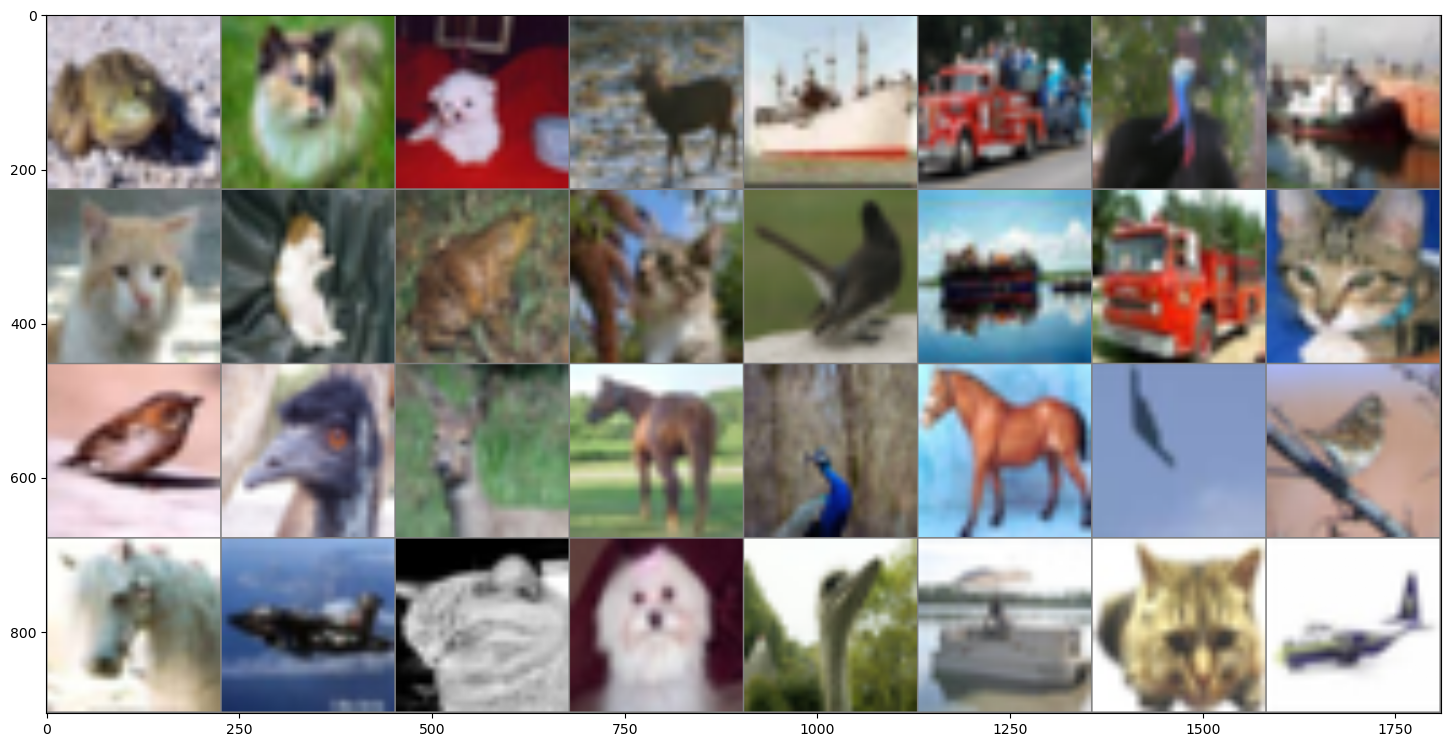

Device: cuda
######### Starting Training ########


  1%|▏         | 22/1563 [00:05<06:29,  3.95it/s]


KeyboardInterrupt: 

In [ ]:
data_transforms = [
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
]

trainloader, testloader = get_dataset(dataset_name='cifar10', transform=data_transforms, batchsize = BATCH_SIZE)
imshow(testloader)

device = get_default_device()

trained_model = train(net=model,
                      epochs=10,
                      trainloader = trainloader,
                      criterion = nn.CrossEntropyLoss(),
                      optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
                      device = device,
                      every_n_epochs = 1)

In [ ]:
PATH = './trained_models/resnet'
create_directory(PATH)
save_model(PATH, model=trained_model, weights='resnet.pth')